# **NAPQUEEN TASK 1**

## IntroductionIn this notebook, we address Task 1 of the NapQueen project, which focuses on forecasting unit sales for various items using historical sales data. Accurate sales forecasting is crucial for effective inventory management, demand planning, and strategic decision-making. To achieve this, we will apply a range of time series analysis techniques..

In [43]:
import pandas as pd
import pmdarima as pm   # provides statistical models for time series forecasting, particularly ARIMA (AutoRegressive Integrated Moving Average) models
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta    # supplies classes for manipulating dates and times. 

In [44]:
# Importing the datasets i.e., both train and test dataset files
train_data = pd.read_csv("C:\\Users\\Paritosh Mathur\\Downloads\\train.csv")
test_data = pd.read_csv("C:\\Users\\Paritosh Mathur\\Downloads\\test.csv")

### The below code converts the date columns in train_data and test_data DataFrames to datetime objects using the pd.to_datetime() function from the pandas library. The errors='coerce' argument ensures that any values that cannot be parsed as dates are set to NaT (Not a Time) rather than causing an error. This helps in handling and cleaning date data more robustly.

In [24]:
train_data['date'] = pd.to_datetime(train_data['date'], errors='coerce')
test_data['date'] = pd.to_datetime(test_data['date'], errors='coerce')

### The below code cleans the train_data DataFrame by removing rows with missing Item Id or units, filtering out rows with negative units or unit_price, and filling any missing values in the ad_spend column with 0.

In [25]:
train_data = train_data.dropna(subset=['Item Id', 'units'])
train_data = train_data[(train_data['units'] >= 0) & (train_data['unit_price'] >= 0)]
train_data['ad_spend'] = train_data['ad_spend'].fillna(0)

## **Exploratory Data Analysis**

### The plot_time_series function plots a time series graph of units sold for a specific item identified by item_id. It filters the train_data DataFrame for the given item, then creates a line plot of units sold over time with labeled axes and a legend.

In [26]:
def plot_time_series(item_id):
    item_data = train_data[train_data['Item Id'] == item_id]
    plt.figure(figsize=(12, 6))
    plt.plot(item_data['date'], item_data['units'], label='Units Sold')
    plt.title(f'Time Series for Item ID: {item_id}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

### The below code plots time series graphs for the first three unique `Item Id` values in the `train_data` DataFrame using the `plot_time_series` function.

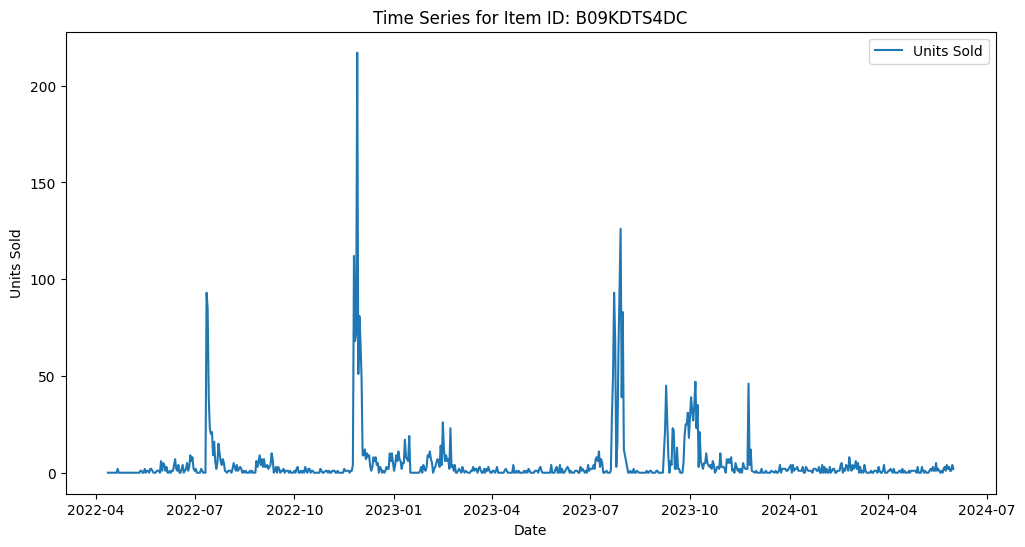

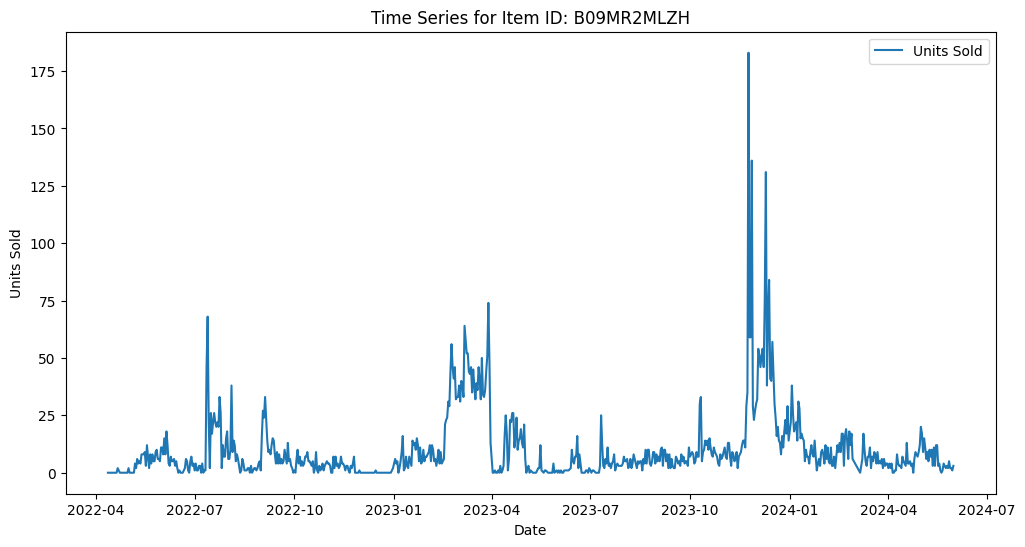

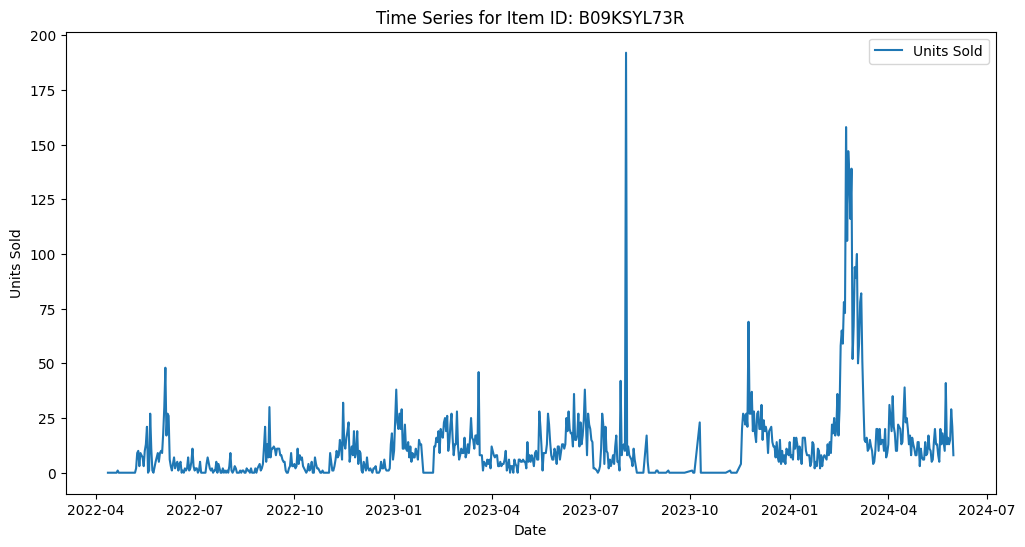

In [27]:
for item_id in train_data['Item Id'].unique()[:3]:
    plot_time_series(item_id)

### This below code creates a histogram with a kernel density estimate (KDE) to show the distribution of units sold in the train_data DataFrame. The plot has 50 bins and includes labels for the title and axes.

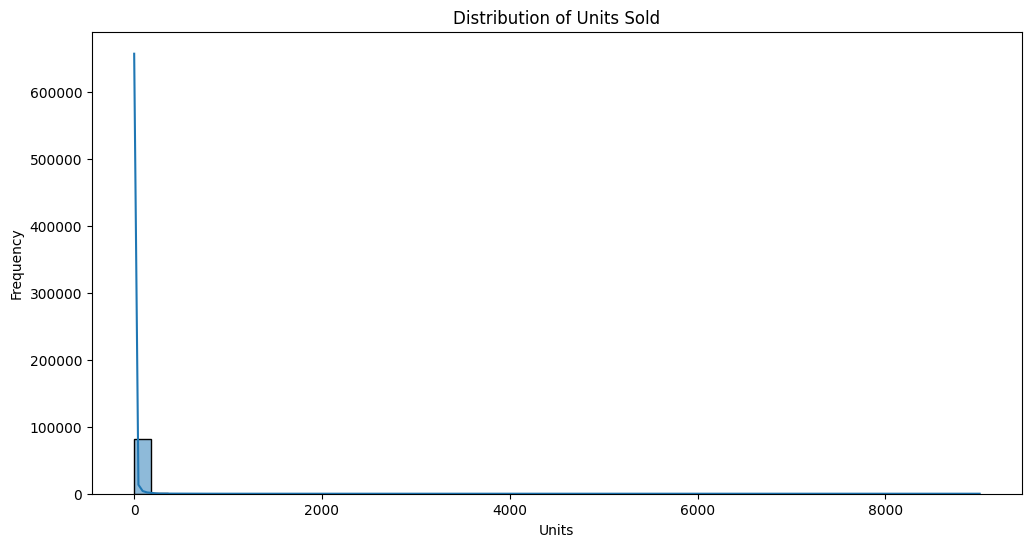

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(train_data['units'], bins=50, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units')
plt.ylabel('Frequency')
plt.show()

### This code creates a histogram with a kernel density estimate (KDE) to display the distribution of unit prices in the train_data DataFrame. The plot uses 50 bins and includes a title and axis labels.

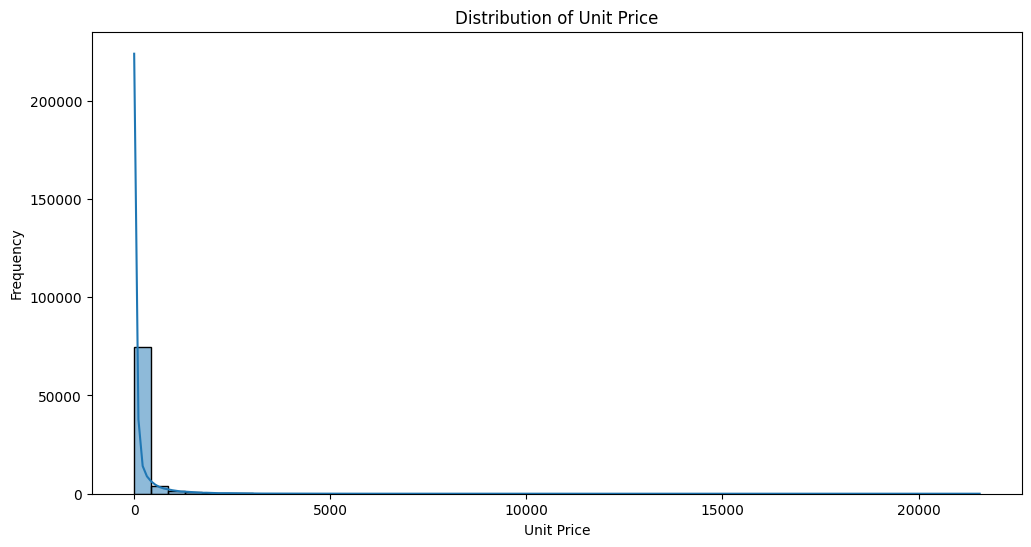

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(train_data['unit_price'], bins=50, kde=True)
plt.title('Distribution of Unit Price')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

## **Feature Engineering**

### The `create_features` function adds new columns to a DataFrame `df` based on the `ds` (date) column. It extracts the day of the week, day of the month, month, and week of the year from the date and includes these as new features in the DataFrame.

In [30]:
def create_features(df):
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['day_of_month'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['week_of_year'] = df['ds'].dt.isocalendar().week
    return df

## **Model Selection**

### The `prepare_item_data` function prepares data for a specific `item_id` by filtering it, selecting relevant columns, renaming them for consistency, and adding date-based features using `create_features`. It handles both training and non-training data differently by including or excluding the `units` column and renaming it to `y` for training data.

In [31]:
def prepare_item_data(item_id, data, is_train=True):
    item_data = data[data['Item Id'] == item_id].copy()
    columns = ['date', 'ad_spend', 'unit_price'] if not is_train else ['date', 'units', 'ad_spend', 'unit_price']
    item_data = item_data[columns]
    item_data = item_data.rename(columns={'date': 'ds'})
    if is_train:
        item_data = item_data.rename(columns={'units': 'y'})
    item_data = create_features(item_data)
    return item_data

## **HyperParameter Tuning**

### The `tune_and_forecast` function forecasts future values for a specific `item_id`. It prepares the training and test data, trains an ARIMA model on the training data, and generates forecasts for the test period. If there's no training data or an invalid prediction range, it prints a warning and skips forecasting. Otherwise, it returns a list of forecasted values with dates and item IDs.

In [32]:
def tune_and_forecast(item_id, train_data, test_data):
    item_train_data = prepare_item_data(item_id, train_data, is_train=True)
    item_test_data = prepare_item_data(item_id, test_data, is_train=False)


    if item_train_data.empty:
        print(f"Warning: No training data for item {item_id}. Skipping forecast.")
        return []

    model = pm.auto_arima(
        item_train_data['y'],
        exogenous=item_train_data[['ad_spend', 'unit_price', 'day_of_week', 'day_of_month', 'month', 'week_of_year']],
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        seasonal=False,
        stepwise=True,
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )

    n_periods = min(15, len(item_test_data))
    future_exog = item_test_data[['ad_spend', 'unit_price', 'day_of_week', 'day_of_month', 'month', 'week_of_year']]

    start = len(item_train_data)
    end = start + n_periods - 1

    if end > start:
        forecast, _ = model.predict(n_periods=n_periods, exogenous=future_exog,
                                   return_conf_int=True, start=start, end=end)

        forecast_list = []
        for date, yhat in zip(item_test_data['ds'], forecast):
            forecast_list.append({'date': date.strftime('%Y-%m-%d'), 'Item Id': item_id, 'TARGET': int(yhat)})
    else:
        print(f"Warning: Invalid prediction range for item {item_id}. Skipping forecast.")
        forecast_list = []

    return forecast_list

### This code retrieves a list of unique `Item Id` values from the `train_data` DataFrame.

In [33]:
item_ids = train_data['Item Id'].unique()

In [34]:
all_forecasts = []

### This code iterates over each unique `item_id`, generates forecasts using the `tune_and_forecast` function, and appends all the forecasts to the `all_forecasts` list.

In [35]:
for item_id in item_ids:
    forecasts = tune_and_forecast(item_id, train_data, test_data)
    all_forecasts.extend(forecasts)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5835.043, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6346.930, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5881.709, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6071.172, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5835.699, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5834.850, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5989.983, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5835.601, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5834.342, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5874.630, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5828.768, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=5828.417, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5826.897, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5826.063, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]          

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5779.069, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5694.500, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5886.466, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5654.717, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5658.673, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5650.104, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5656.498, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5631.884, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5651.488, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5633.204, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5653.304, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5629.888, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5649.488, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5648.104, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5631.207, Time=0.27 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5704.220, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5645.899, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5875.665, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5646.189, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5647.178, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5643.914, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5644.312, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5644.202, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5702.223, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5645.190, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.283 seconds
Performing stepwise search to minimize aic


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9573.419, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9696.475, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9679.885, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9647.831, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9694.476, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9564.249, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9604.852, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9558.021, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9602.505, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9554.825, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9553.604, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9554.727, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9555.062, Time=0.82 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9556.618, Time=0.74 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9556.702, Time=0.94 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6550.608, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6540.272, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6585.816, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6517.761, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6518.269, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6529.503, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6549.096, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6515.182, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6505.219, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6505.717, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6506.127, Time=0.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6507.920, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6503.219, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6513.182, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6503.717, Time=0.12 sec
 ARIMA(3,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6735.600, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6727.639, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6725.948, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6733.617, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6721.559, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6723.063, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6719.594, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6723.971, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=6721.106, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]    

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7553.536, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7629.780, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7588.760, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7576.175, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7627.780, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7573.600, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7569.668, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7573.329, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7571.873, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7571.629, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7553.141, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7574.176, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7586.760, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7571.601, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7567.671, Time=0.17 sec
 ARIMA(0,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6632.037, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6094.987, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6079.692, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6449.065, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6077.764, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6070.614, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6079.893, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6070.019, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6078.358, Time=0.32 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6067.452, Time=0.75 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6070.660, Time=0.49 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6067.312, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6069.037, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6069.901, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6080.782, Time=0.35 sec

Best mode

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2234.927, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2616.818, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2453.750, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2238.091, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2614.820, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2236.817, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2237.163, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2235.046, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2367.135, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2238.171, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2233.082, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2236.214, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2451.753, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2234.976, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2235.304, Time=0.13 sec
 ARIMA(0,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5004.225, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5076.499, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5013.435, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5003.037, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5074.517, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5004.367, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5001.090, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5002.288, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5002.427, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5011.469, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.463 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6598.266, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6606.781, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6549.278, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6545.253, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6542.822, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6543.903, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6544.397, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6543.762, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6547.078, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6544.526, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6544.393, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6540.862, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6543.306, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6541.953, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6542.436, Time=0.27 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9405.013, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9644.235, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9488.906, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9403.427, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9642.236, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9404.993, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9392.941, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9386.358, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9387.992, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9341.791, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9391.112, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9342.361, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9386.906, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=9339.825, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9384.358, Time=0.18 sec
 ARIMA(3,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10862.084, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10810.880, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10898.742, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10780.768, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10817.845, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10770.899, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10770.121, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10791.981, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=10771.027, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=10769.697, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=10821.388, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=10859.679, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=10767.821, Time=0.33 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=10812.629, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10791.050, Time=0.26

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5494.899, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5336.428, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5631.194, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5331.986, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5324.368, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5329.688, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5326.367, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5326.367, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5329.718, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5327.488, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5322.402, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5327.724, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5328.602, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5324.401, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5324.401, Time=0.15 sec
 ARIMA(0,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6055.062, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6186.956, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6142.507, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6126.775, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6184.956, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6052.432, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6130.516, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6054.416, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6054.424, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6052.500, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6126.635, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6055.311, Time=0.78 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6050.433, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6053.062, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6128.517, Time=0.03 sec
 ARIMA(3,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4587.554, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4573.463, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4523.518, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4585.554, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4437.726, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4467.876, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4411.310, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4460.453, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4413.067, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4421.625, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4409.324, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4435.726, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4458.453, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4411.092, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4465.876, Time=0.04 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7347.712, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6886.973, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6994.878, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6868.090, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6886.030, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6842.729, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6881.471, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6839.490, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6852.652, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6823.550, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6822.784, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6821.559, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6834.776, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6885.400, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6977.278, Time=0.06 sec
 ARIMA(1,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2789.968, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2789.976, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2901.281, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2854.032, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2789.616, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2779.525, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2829.962, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2822.864, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2781.294, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2781.284, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2850.951, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2819.814, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2805.637, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2781.497, Time=0.40 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.730 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4440.841, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4441.529, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4419.831, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4439.211, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4404.876, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4403.013, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4404.895, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4440.917, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=4400.105, Time=0.55 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4401.035, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4409.793, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=4401.833, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4408.628, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4411.136, Time=0.37 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0] intercept
Total fit time: 3.852 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2401.068, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2391.078, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2598.850, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2392.852, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2392.828, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2430.537, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2394.045, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.544 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3172.191, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3349.287, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3211.320, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3171.388, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3347.288, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3172.543, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3643.074, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3826.327, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3628.715, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3672.103, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3630.719, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3630.709, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3629.409, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3637.373, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3632.374, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3626.716, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3628.064, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3670.104, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3628.720, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3628.710, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3743.609, Time=0.02 sec
 ARIMA(1,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3442.225, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3441.073, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3422.475, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3440.225, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3229.072, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3224.688, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3219.864, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3225.967, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3221.727, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3217.865, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3224.126, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3222.968, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5402.652, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5858.120, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5415.045, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5529.466, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5342.562, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5487.389, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5344.019, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5344.083, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5455.428, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5345.992, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5337.785, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5418.552, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5383.319, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : 

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4360.779, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4160.978, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4158.765, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4153.205, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4151.613, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4158.328, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4151.813, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4152.768, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4145.867, Time=0.78 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4147.024, Time=0.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4146.069, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 3.636 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4165.692, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]    

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4167.365, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4167.148, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4629.177, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4173.461, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4159.215, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4160.574, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4160.393, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4163.052, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4160.504, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4162.073, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4152.529, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4160.417, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4160.517, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4153.525, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=4153.112, Time=0.33 sec
 ARIMA(1,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5376.684, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5715.002, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5377.465, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5369.490, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5349.217, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5352.346, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5347.779, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5359.092, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5345.781, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5357.094, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5347.218, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5367.493, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]  

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3362.246, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3547.267, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3364.242, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3366.190, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3360.248, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3362.242, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3362.244, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3399.334, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3364.192, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.901 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2777.659, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2964.098, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2775.760, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2797.182, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2738.074, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2755.113, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2733.274, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2733.045, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2731.072, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2790.292, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2733.053, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2778.572, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2734.438, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2729.262, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2744.256, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2742.686, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2730.928, Time=0.62 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2731.025, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2744.337, Time=0.07 sec
 ARIMA(0,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5236.187, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5183.478, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5243.139, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5032.330, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5128.569, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5024.774, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5116.073, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5000.169, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4999.251, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5006.642, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5000.447, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5000.847, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5002.160, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4997.258, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5004.645, Time=0.13 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4499.209, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4872.168, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4500.157, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4495.777, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4483.741, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4491.324, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4480.441, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4478.592, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4513.046, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4524.528, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4476.615, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4489.333, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4511.049, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4478.461, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4522.529, Time=0.03 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2999.820, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3255.583, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3123.845, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3044.283, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3253.584, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2989.502, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3082.310, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2988.841, Time=0.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3082.428, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2983.995, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3003.554, Time=0.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2983.505, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2990.962, Time=0.76 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2981.498, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2988.970, Time=0.28 sec
 ARIMA(3,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4462.493, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4456.018, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4456.715, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4439.387, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4454.163, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4454.008, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4443.254, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4434.087, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4435.055, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4435.019, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4435.021, Time=0.35 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4435.046, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4433.169, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4159.671, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3868.788, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3861.525, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4124.614, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3849.463, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3778.708, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3791.299, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3772.175, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3785.096, Time=0.12 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3766.500, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3777.932, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3774.302, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3845.507, Time=0.25 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0] intercept
Total fit time: 2.140 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2046.238, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1980.641, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1954.681, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1950.548, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1952.110, Time=0.08 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1952.475, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1950.551, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1943.536, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1949.135, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1944.326, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1944.082, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1950.321, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1942.385, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1942.771, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1949.862, Time=0.13 sec

Best mode

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2508.529, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2536.673, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2514.010, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2509.865, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2502.283, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2534.855, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2520.715, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2503.040, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2502.437, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2571.998, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2521.873, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2505.805, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2502.379, Time=0.35 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.218 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5894.388, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5894.388, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5904.706, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5903.161, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5895.541, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5888.354, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5893.256, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5893.060, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5890.055, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5890.006, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5893.553, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5894.229, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5893.479, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5891.721, Time=0.51 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 2.250 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1944.304, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1980.234, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1945.848, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1945.850, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1943.935, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2012.267, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1945.848, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2001.069, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1945.030, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1937.365, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1960.184, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1945.173, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1939.365, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1939.365, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1969.347, Time=0.04 sec
 ARIMA(0,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5751.834, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5878.823, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5711.235, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5711.140, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5710.751, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5759.030, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5709.645, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5707.285, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5749.834, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5819.055, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5709.235, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5709.140, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5708.751, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5757.030, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5707.645, Time=0.13 sec

Best mode

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1148.436, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1316.381, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1137.755, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1204.289, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1139.422, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1139.646, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1138.845, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1195.439, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1141.728, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1135.776, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1136.825, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1202.290, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1137.438, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1137.666, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1221.941, Time=0.01 sec
 ARIMA(1,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4089.196, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4773.191, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4113.798, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4401.958, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4083.192, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4097.950, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4084.133, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4084.618, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4082.793, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4255.357, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4084.361, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4221.237, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4084.945, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4068.210, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4161.551, Time=0.12 sec
 ARIMA(1,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1182.370, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1183.506, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1179.699, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1180.252, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1180.374, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1247.038, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1181.509, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.522 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4715.614, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5005.829, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4719.442, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4748.007, Time=0.02 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4706.029, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4719.311, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4681.703, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4691.917, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4678.147, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4677.330, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4674.418, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4731.598, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4676.319, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4717.604, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4678.325, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4664.610, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4683.252, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4679.201, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4666.130, Time=0.38 sec
 ARIMA(1,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=436.066, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=436.035, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=461.152, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=459.298, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=438.955, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=433.237, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=431.238, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=429.246, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=431.238, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.662 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5112.938, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5475.562, Time=0.02 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5143.462, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5286.018, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5104.408, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5115.787, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5118.369, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5114.733, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5113.172, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=5117.621, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5094.482, Time=0.24 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=5096.374, Time=0.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5098.579, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5089.624, Time=0.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5092.323, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5092.757, Time=0.39 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=5091.316, Time=0.64 sec
 ARIMA(2,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4950.227, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5115.038, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4986.237, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4952.222, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4941.965, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5105.094, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5008.992, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4943.237, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4943.215, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5261.057, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5047.079, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4966.808, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4945.201, Time=0.33 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.770 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1951.513, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2256.151, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1953.504, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1954.279, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1949.514, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1951.503, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1951.506, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2070.319, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1952.279, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.969 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3068.006, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3341.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3194.930, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3066.360, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3067.967, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3068.848, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3064.365, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3066.010, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3065.971, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3192.931, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3066.853, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.715 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=483.052, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=513.654, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=499.897, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=504.896, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=482.276, Time=0.07 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=481.094, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=482.205, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=483.952, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=470.536, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=482.861, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=472.421, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=472.459, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=476.021, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=473.246, Time=0.41 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.216 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3739.729, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4024.630, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3846.525, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3738.027, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]        

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2136.405, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2529.689, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2158.010, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2318.868, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2138.066, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2137.992, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2243.419, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2140.724, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2139.869, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2130.970, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2271.077, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2146.999, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2132.880, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2132.846, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2422.395, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2751.371, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2583.006, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2420.649, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2749.371, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2422.411, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2423.913, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2418.652, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2420.398, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2420.413, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2581.006, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2421.915, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.050 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5406.682, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5411.725, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5543.992, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5361.261, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5381.697, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5360.414, Time=0.42 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5368.824, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5360.715, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5358.420, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5359.266, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5366.829, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5324.603, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5358.721, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5326.601, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5360.652, Time=0.16 sec

Best model:  A

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5134.907, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5271.445, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5204.622, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5157.762, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5269.445, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5138.386, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5125.841, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5137.314, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5124.438, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5127.325, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5137.335, Time=0.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5122.439, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]  

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6228.437, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6339.271, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6229.734, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6203.175, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6193.131, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6192.434, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6202.567, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6192.230, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6195.333, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6190.231, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6190.435, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6193.334, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6200.568, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4852.149, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4420.253, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4416.342, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4414.198, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4414.651, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4413.504, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4411.840, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4679.046, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4413.439, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4568.413, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4390.528, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4517.246, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4392.085, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4409.272, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4345.075, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4417.821, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4222.977, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4285.040, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4196.693, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4277.871, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4196.364, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4198.951, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4200.413, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4194.989, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4197.308, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4195.433, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4198.847, Time=0.31 sec
 ARIMA(2,1,1)(0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5216.053, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5177.955, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=5191.905, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5177.832, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5175.867, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5177.545, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5177.562, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5175.675, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5227.194, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5235.368, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5164.513, Time=0.31 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5176.190, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5164.068, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5176.894, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5171.522, Time=0.15 sec
 ARIMA(2,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3551.327, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3297.321, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3299.392, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3291.986, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3613.919, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3308.772, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3293.666, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3293.277, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3975.989, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3499.306, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3292.325, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3295.063, Time=0.23 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.227 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3156.211, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3186.694, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3127.191, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3127.195, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3130.634, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3173.947, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3128.983, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3117.429, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3126.433, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3129.770, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3119.403, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3119.407, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3135.654, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3119.881, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3128.712, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3120.994, Time=0.61 sec

Best mode

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3503.340, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3503.349, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3501.409, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3552.137, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3504.489, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3499.513, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3501.255, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3588.856, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3501.491, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3501.503, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3499.557, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3550.164, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3502.654, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.668 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4292.938, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4260.424, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4336.184, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4251.583, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4249.605, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4251.534, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4249.941, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4247.606, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4258.425, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4249.584, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4249.535, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4249.229, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4247.943, Time=0.16 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.074 seconds
Perf

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3474.759, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3637.472, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3558.880, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3485.479, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3635.472, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3475.006, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3474.501, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3476.269, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3474.360, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3473.788, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[0]            

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2618.211, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2489.238, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2518.260, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2494.163, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2516.741, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2487.265, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2490.409, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2516.263, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2492.171, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2553.967, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]            

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5705.746, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5754.950, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5637.491, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5637.490, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5663.798, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5705.823, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5636.264, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5633.518, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5703.746, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5723.394, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5635.493, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5635.492, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5661.799, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5703.823, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5634.266, Time=0.28 sec

Best mode

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3414.419, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3402.009, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3409.362, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3404.008, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3404.923, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3392.337, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3392.615, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3393.574, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3394.227, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3395.140, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3393.157, Time=0.18 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 1.966 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1861.545, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2246.160, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1981.863, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1864.805, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1864.365, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1845.804, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1958.043, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1877.462, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1844.801, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1844.066, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1844.082, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1842.774, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1844.257, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1845.587, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1861.334, Time=0.13 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 1.543 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4335.644, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4335.191, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4332.957, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4382.033, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4332.186, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4347.349, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4313.680, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4312.793, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4311.581, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4475.465, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4378.569, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4312.944, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4546.037, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=4421.231, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=4313.722, Time=0.67 sec
 ARIMA(1,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6041.790, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6050.551, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6024.645, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6026.950, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6014.386, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6019.253, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=6014.211, Time=0.41 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6019.605, Time=0.14 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6011.423, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6011.893, Time=0.45 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6010.088, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6010.384, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6012.652, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6023.645, Time=0.25 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0] intercept
Total fit time: 4.006 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1640.317, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1642.317, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1636.935, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1638.318, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1638.317, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1709.233, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1640.317, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.631 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3247.071, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3317.318, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3261.068, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3245.902, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3315.324, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3245.583, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3016.895, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3008.030, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3002.775, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3001.850, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3005.395, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3002.428, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3002.927, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2999.858, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3014.958, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3003.406, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3000.437, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3000.784, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3029.826, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3006.043, Time=0.05 sec
 ARIMA(3,1,0)(0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6862.460, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6819.737, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6829.400, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=6805.799, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6804.009, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6802.016, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7189.878, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6804.004, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=7077.557, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6806.001, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6800.673, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=7056.267, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6874.556, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6802.677, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6802.673, Time=0.27 sec
 ARIMA(0,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2868.915, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2644.268, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2632.376, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2615.153, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2614.885, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2619.640, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2615.066, Time=0.16 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 0.700 seconds


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5361.322, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5488.934, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5428.521, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5388.146, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5486.938, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5387.890, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5361.591, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5366.729, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5390.642, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5351.756, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5340.784, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5356.795, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5342.684, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5345.148, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0]          

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1780.405, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1963.095, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1803.778, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1775.421, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1773.774, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1777.454, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1775.751, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1775.441, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1764.983, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1769.491, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1765.121, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1767.637, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1773.529, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1767.725, Time=0.20 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0] intercept
Total fit time: 2.429 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=820.254, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=824.695, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=824.885, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=822.951, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=824.465, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=819.312, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=822.708, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=821.914, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=822.937, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=823.692, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=820.993, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=821.064, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             :

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=970.544, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1011.953, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=977.870, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=984.648, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=963.223, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=978.054, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=965.027, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=965.087, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=963.265, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=978.579, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=959.859, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=959.272, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=958.548, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=973.034,

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=442.452, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=524.531, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=468.926, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=489.588, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=442.372, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=457.510, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=444.056, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=443.354, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=442.610, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=455.251, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=444.776, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=440.796, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=439.993, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=456.373, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=449.2

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=949.873, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1136.370, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=945.623, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=947.322, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=947.182, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=945.920, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=946.609, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=949.120, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=943.647, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=947.417, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=948.084, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=945.338, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=945.195, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=947.891, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]     

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2001.120, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2013.597, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2003.002, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2002.995, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2015.100, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2004.954, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2000.450, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2000.681, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2000.662, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2002.435, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2002.431, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1999.373, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2097.520, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2016.896, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.527 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2000.247, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2001.069, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2000.384, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2032.191, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2002.757, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1995.775, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1997.979, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2015.929, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1996.650, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1997.446, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2051.872, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1996.563, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2016.114, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1999.115, Time=0.55 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 2.568 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1425.975, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1445.913, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1423.749, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1422.668, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1420.668, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1443.913, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1421.749, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1423.975, Time=0.04 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.630 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=510.140, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=586.762, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=536.125, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=508.150, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=584.762, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] int

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=132.735, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=133.402, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.515, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=133.225, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=135.045, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.490 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=321.754, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=344.064, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=336.042, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=339.165, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=323.716, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=323.721, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=335.617, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=330.253, Time=0.01 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=325.649, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=318.865, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=319.555, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=319.244, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=320.391, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=320.306, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=318.860, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.498 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2148.688, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2469.618, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2146.753, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2272.759, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2148.694, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2149.946, Time=0.09 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2143.066, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2426.673, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2144.747, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2144.733, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2244.922, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2146.720, Time=0.18 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.538 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=455.405, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=412.520, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=453.405, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=389.302, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=375.847, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   :

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1222.836, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1470.547, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1293.629, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1378.557, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1222.834, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1237.158, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1224.740, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1221.484, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1222.926, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1223.262, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1223.236, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1224.883, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1215.719, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : 

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=595.164, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=594.308, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=593.796, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=632.691, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=594.665, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=622.461, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=596.307, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=592.158, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=611.526, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=593.817, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=592.431, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=592.494, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=613.605, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=605.592, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=592.992, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0] i

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1538.406, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1574.040, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1573.774, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1571.387, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1572.040, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1531.936, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1560.126, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1533.636, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1534.275, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1532.400, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1557.678, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1533.148, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1529.936, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1536.406, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]          

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1056.840, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1122.801, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1074.775, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1058.745, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1049.984, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1091.482, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1071.524, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1051.968, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1051.965, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1131.631, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1080.562, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1059.958, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1053.871, Time=0.17 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.942 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=837.523, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=823.484, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=822.403, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=820.626, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=843.285, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=822.472, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=836.967, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=823.954, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=820.608, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=824.648, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=824.422, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=822.326, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=822.412, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=822.878, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=823.207, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] i

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1096.632, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1096.485, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1096.011, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1100.744, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1098.712, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1091.094, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1090.552, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1112.794, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1093.712, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1091.001, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1166.361, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1101.424, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1092.388, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1092.993, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.005 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3478.588, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3680.762, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3591.697, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3489.295, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3678.762, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3479.812, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3477.708, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3479.847, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3479.730, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3477.093, Time=0.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3481.067, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3477.590, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3475.094, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3479.069, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]          

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=509.097, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=499.199, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=496.581, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=503.415, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=488.610, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=490.354, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=492.354, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=486.635, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=494.599, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=488.390, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=501.422, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=490.381, Time=0.08 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 2.430 seconds
Performing stepwise s

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=948.757, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=950.751, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=950.753, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=975.658, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.460 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=124.513, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=223.518, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=171.324, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=126.717, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=221.518, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=125.677, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=122.973, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=563.160, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=546.032, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=535.121, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=524.479, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=534.032, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=530.517, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=526.471, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=526.469, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=544.247, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=532.063, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=528.022, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=528.039, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.762 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=642.907, Time=0.08 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=694.125, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=660.303, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=667.421, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=664.765, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=658.497, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=629.685, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=628.017, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=636.602, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=629.832, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=627.692, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=629.686, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=631.684, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] 

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=212.755, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=208.142, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=229.225, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=210.114, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=210.105, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=212.353, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=211.119, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.467 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=766.904, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=902.289, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=851.058, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=766.131, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=900.300, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=766.453, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept  

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2703.006, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2434.893, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2446.772, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2436.875, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2436.867, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2435.278, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2439.473, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2438.891, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2430.488, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2431.038, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2436.628, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2432.451, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2432.044, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2449.154, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2430.416, Time=0.11 sec
 ARIMA(0,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=642.457, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=638.405, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=638.999, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=639.545, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=642.301, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=640.459, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.313 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5208.763, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5631.882, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5208.209, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5362.643, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5209.484, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5193.109, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5185.218, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]     

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4782.150, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4799.128, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4774.919, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4773.312, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4771.397, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4784.493, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4773.318, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4784.177, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4775.381, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4770.239, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4773.868, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4773.752, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4771.925, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4771.907, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4772.697, Time=0.07 sec
 ARIMA(0,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3067.729, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3068.630, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3063.828, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3065.803, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3065.794, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3140.729, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3066.674, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.675 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4756.237, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4892.471, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4881.120, Time=0.02 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4837.454, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4890.471, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4748.348, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4813.561, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4741.050, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4802.445, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4743.050, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4742.724, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4739.062, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4746.351, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4800.445, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4741.062, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4811.561, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4740.729, Time=0.25 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 2.588 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3539.801, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3589.169, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3425.053, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3488.545, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3411.504, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3486.953, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3399.425, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3398.040, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3396.273, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3394.997, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3396.328, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3398.192, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3393.008, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3537.801, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3394.281, Time=0.06 sec
 ARIMA(0,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=329.020, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=459.958, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=327.728, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=381.335, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=328.154, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=326.936, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=325.183, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=327.748, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=326.941, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=326.507, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=328.932, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=325.088, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=327.883, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=328.555, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=326.672, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]  

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4057.457, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4099.461, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4018.290, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4044.667, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4019.601, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4018.786, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4016.884, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4014.983, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4016.894, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4018.733, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4013.053, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4055.491, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4014.954, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4014.964, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4021.075, Time=0.05 sec
 ARIMA(1,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1995.521, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1997.056, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1990.068, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1996.941, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1991.993, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1991.996, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1990.009, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1997.754, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1991.996, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1998.895, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1993.230, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1990.356, Time=0.28 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.166 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=237.409, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=247.819, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=240.662, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=234.235, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=234.707, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=234.117, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=235.236, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=233.729, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=235.612, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=235.684, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=235.502, Time=0.10 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.750 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=715.551, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=914.450, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=799.287, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept  

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=293.839, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=290.886, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=288.891, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=287.264, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=285.561, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=283.814, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=285.590, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.165 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1333.682, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1420.031, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1340.390, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1322.087, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1341.163, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1322.488, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1321.470, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1320.110, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1350.370, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1321.614, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1343.821, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1322.676, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1314.497, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1319.960, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1319.152, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1314.873, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1314.752, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1318.619, Time=0.03 sec
 ARIMA(0,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=273.368, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=286.001, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=284.153, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=275.150, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=269.816, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=270.534, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=270.448, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=271.586, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=271.528, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=271.688, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=272.470, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=272.441, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=273.320, Time=0.20 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.161 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept  

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=222.531, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=231.530, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=227.047, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=224.180, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=217.783, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=221.660, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=220.109, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=218.709, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=218.053, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=224.452, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=217.050, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=217.399, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=218.245, Time=0.13 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 0.942 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]            

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=429.594, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=430.504, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=429.682, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=428.630, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=408.144, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=406.152, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=404.296, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=406.149, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=201.419, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=222.641, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=219.4

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1375.723, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1377.060, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1377.710, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1377.708, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1375.715, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1377.709, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1379.708, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.403 seconds


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=917.914, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=974.324, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=938.273, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=920.145, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=972.324, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=918.919, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=930.608, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=915.915, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=918.145, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=936.274, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=909.364, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=928.608, Time=0.0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=417.162, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=440.521, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=430.604, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=418.541, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=413.167, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=424.719, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=423.119, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=414.272, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=413.907, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=428.268, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=423.785, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=420.159, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=412.077, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=407.121, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=414.390, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0] i

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=315.694, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=312.380, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=314.365, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=314.368, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=342.593, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=313.701, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.381 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=201.551, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=234.522, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=234.676, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=235.271, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=196.772, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=225.629, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=198.127, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]            

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=309.963, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=311.803, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=306.581, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=307.882, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=307.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=342.258, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=309.813, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.514 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=489.112, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=491.021, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=491.035, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=479.944, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=481.635, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : A

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=319.837, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=323.173, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=308.929, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=321.681, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=309.136, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=322.393, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=309.872, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=307.752, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=305.770, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=304.315, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=307.728, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=305.783, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=305.019, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.068 seconds
Performing stepwi

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=653.168, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=666.821, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=653.941, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=654.264, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=652.267, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=668.325, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=654.263, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=669.854, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=656.003, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=651.388, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=650.771, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=648.946, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=661.775, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=650.792, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=649.235, Time=0.02 sec

Best model:  ARIMA(0,0,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=253.438, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=253.492, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=252.455, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=285.005, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=255.534, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=250.105, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=255.939, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=314.892, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=252.073, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=252.089, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=250.971, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=283.008, Time=0.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=254.076, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.195 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]            

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=110.106, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=101.716, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=110.972, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=103.330, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=100.983, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=102.389, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=104.185, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=102.687, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=108.836, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=103.828, Time=0.14 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0] intercept
Total fit time: 1.018 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3228.602, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4189.670, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3227.633, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]         

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=344.815, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=288.163, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=249.541, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=342.815, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=250.778, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=253.213, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=247.734, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=248.811, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=249.055, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=286.163, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=251.397, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.685 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=693.968, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1083.643, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1093.317, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1035.294, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1035.296, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1081.517, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1066.892, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1037.121, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1028.995, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1043.330, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1041.854, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1030.992, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1030.992, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1047.411, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1040.642, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1038.132, Time=0.03 sec
 ARIMA(2,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=246.241, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=244.102, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=246.255, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=238.818, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=237.569, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=239.450, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=237.419, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=239.645, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=239.630, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=237.597, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=237

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.356, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=30.674, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32.908, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31.022, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27.504, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=36.163, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32.368, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=29.412, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=29.448, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=31.226, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.311, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=31.093, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
To

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=62.925, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=62.764, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=67.957, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=67.568, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=59.569, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=57.608, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=55.909, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=57.646, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.609 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=754.113, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=799.861, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=752.459, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=761.125, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=754.1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3686.646, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3744.412, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3613.423, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3663.186, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3603.380, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3660.554, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3600.098, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3599.903, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3601.802, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3602.685, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3602.993, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3594.849, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3592.849, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3600.685, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3598.098, Time=0.20 sec
 ARIMA(2,1

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4456.167, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4452.449, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4646.449, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4454.438, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4454.438, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4525.191, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4455.968, Time=0.20 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.938 seconds


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=595.128, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=708.767, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=650.296, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=593.364, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=706.767, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=595.111, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=594.988, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=591.380, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=593.142, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=593.126, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=648.298, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=593.003, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.702 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3925.452, Time=

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1198.887, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1200.606, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1200.612, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1206.424, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1206.350, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1202.655, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1197.549, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1195.604, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1193.786, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1253.954, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1195.595, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1208.104, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.380 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1322.583, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1243.561, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1259.014, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1245.092, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1273.026, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1244.381, Time=0.12 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 0.624 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=768.704, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=837.462, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=781.428, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=788.804, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=757.512, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=782.909, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=755.450, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=776.207, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]       

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4117.777, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4119.615, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4119.616, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4124.386, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4124.180, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4121.689, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4117.960, Time=0.46 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.339 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3675.340, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3869.087, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3776.976, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3680.435, Time=0.07 sec


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3867.087, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3677.184, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3676.664, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3675.649, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3730.303, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3678.864, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3673.360, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3678.439, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3774.976, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3675.208, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3674.703, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3673.665, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3728.303, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3676.881, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.653 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2959.889, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2959.855, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2959.037, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2971.496, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2958.673, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2952.684, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2955.380, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2966.568, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2954.683, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2954.683, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2987.300, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2952.968, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2959.381, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2953.579, Time=0.39 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 2.307 seconds

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1182.010, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1043.915, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1043.794, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1069.033, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1044.810, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.475 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9.353, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13.353, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11.353, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11.353, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12.371, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.076 seconds
Performing stepwise search to minimize aic


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=239.451, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=214.000, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=237.451, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=199.995, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=175.796, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=152.630, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=156.948, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=154.536, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=150.631, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=155.011, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=173.796, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=152.536, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             :

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=112.179, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=111.826, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=111.994, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=113.222, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.411 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-35.638, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-39.638, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-37.638, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-37.638, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-38.649, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.081 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-51.205, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-55.205

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1500.871, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1505.677, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1502.866, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1502.863, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1501.363, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1503.782, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1501.752, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1500.139, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1500.577, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1502.010, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1501.710, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1501.890, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1502.725, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1499.942, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1520.490, Time=0.10 sec
 ARIMA(1,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1562.327, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1504.734, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1486.272, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1539.752, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1488.243, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1488.251, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1525.871, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1489.891, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1485.976, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1524.417, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1497.940, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1487.848, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1487.881, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1541.005, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1513.424, Time=0.09 sec
 ARIMA(2,0

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=205.445, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=226.702, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=215.503, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=217.277, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=207.243, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=218.708, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=215.896, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=201.541, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=201.797, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=201.806, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=203.365, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=204.354, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   :

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=986.462, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=981.134, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=928.012, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=986.146, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=920.280, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=963.553, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=921.552, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=921.204, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=919.264, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=920.787, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=921.206, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=919.229, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] 

C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=239.764, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=313.621, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=241.716, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=241.048, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=237.849, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=239.811, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=239.799, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=283.040, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=239.125, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.049 seconds
Performing stepwise search to minimize aic


C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Paritosh Mathur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15.496, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11.496, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13.496, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13.496, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.488, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.161 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3002.043, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3193.176, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3010.500, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3021.676, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2990.666, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3010.933, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2980.598, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2979.105, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercep

KeyboardInterrupt: 

In [36]:
forecast_df = pd.DataFrame(all_forecasts)

In [37]:
print(forecast_df.head())

         date     Item Id  TARGET
0  2024-07-01  B09KDTS4DC       3
1  2024-07-02  B09KDTS4DC       3
2  2024-07-03  B09KDTS4DC       3
3  2024-07-04  B09KDTS4DC       3
4  2024-07-05  B09KDTS4DC       4
